# Prepare

## Import

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
from copy import deepcopy
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
# sys.path.append('C:\\_Lib\\python\\multimode')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, get_current_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [2]:
import json
import os
# path = os.getcwd()
path = r'H:\Shared drives\SLab\Multimode\experiment\250505_qsim' # for data 
print("path: ", path)

path:  H:\Shared drives\SLab\Multimode\experiment\250505_qsim


## Setup experiment hardware

In [3]:
expt_path = os.path.join(path, 'data')

print('Data will be stored in', expt_path)

Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data


In [4]:
curr_path = os.getcwd()
config_file = os.path.join(curr_path, 'hardware_config_202505.yml')
config_path = config_file
print('Hardware configs will be read from', config_path)

exp_param_file = os.path.join(curr_path, 'experiment_config.yml')
exp_param_path = exp_param_file
print('Experiment params will be read from', exp_param_path)

Hardware configs will be read from C:\_Lib\python\multimode_expts\hardware_config_202505.yml
Experiment params will be read from C:\_Lib\python\multimode_expts\experiment_config.yml


In [5]:
qubit_i = 0
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [6]:
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab
im.keys()

dict_keys(['Pyro.NameServer', 'Qick101'])

In [7]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x22e16f35340; not connected; for PYRO:obj_27c6c8a10aee4ded81304a04059596a3@192.168.137.101:37755>


In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.180
	Firmware timestamp: Tue Oct 15 12:06:51 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 32768 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 32768 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 32768 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 32768 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 32768 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 32768 samples
		DAC ti

In [9]:
soc.cycles2us(1)

0.0023251488095238095

## Choose experiment name

In [10]:
# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
sys.path.insert(0, expts_path)
print('Path added at highest priority')

# Verify the path is added
print(sys.path)

# Import the experiments module from multimode
import experiments as meas

# Verify the module is imported from the correct path
print(meas.__file__)

Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'C:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib', 'C:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\Pythonwin', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-pa

# Qubit characterization

Handling of parameter updating: 

The experiment objects are initialized with the `config_path`, meaning they will read from our hardware config file and set the `self.cfg` to that. 
But here we will be overriding that immediately with a new config AttrDict that is at first just a deepcopy of that yaml file but as we go over each cell the values inside this `config_thisrun` will be gradually updated. 
Throughout the notebook, the updated config will only live in memory, until you decide to write it to disk.

In [11]:
config_thisrun = AttrDict(deepcopy(yaml_cfg))

## Resonator spectroscopy

  0%|          | 0/250 [00:00<?, ?it/s]

[748.99, 5000, 1000, 0, 357.08265809341225, 118.47302782748213, -1.0325156850998813]
[ 7.48856197e+02 -6.99324287e+02  1.29802514e+05 -3.30730565e-01
  6.89397463e+04  3.88210513e+02 -6.17335741e+00]

Freq with minimum transmission: 747.26
Freq with maximum transmission: 749.06
From fit:
	f0: 748.8561966555017
	Qi: -699.3242868989879
	Qe: 129802.51442499357
	Q0: -703.112376548234
	kappa [MHz]: -1.0650590455139421
	phi [radians]: -0.3307305652847543
Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00007_ResonatorSpectroscopyExperiment.h5


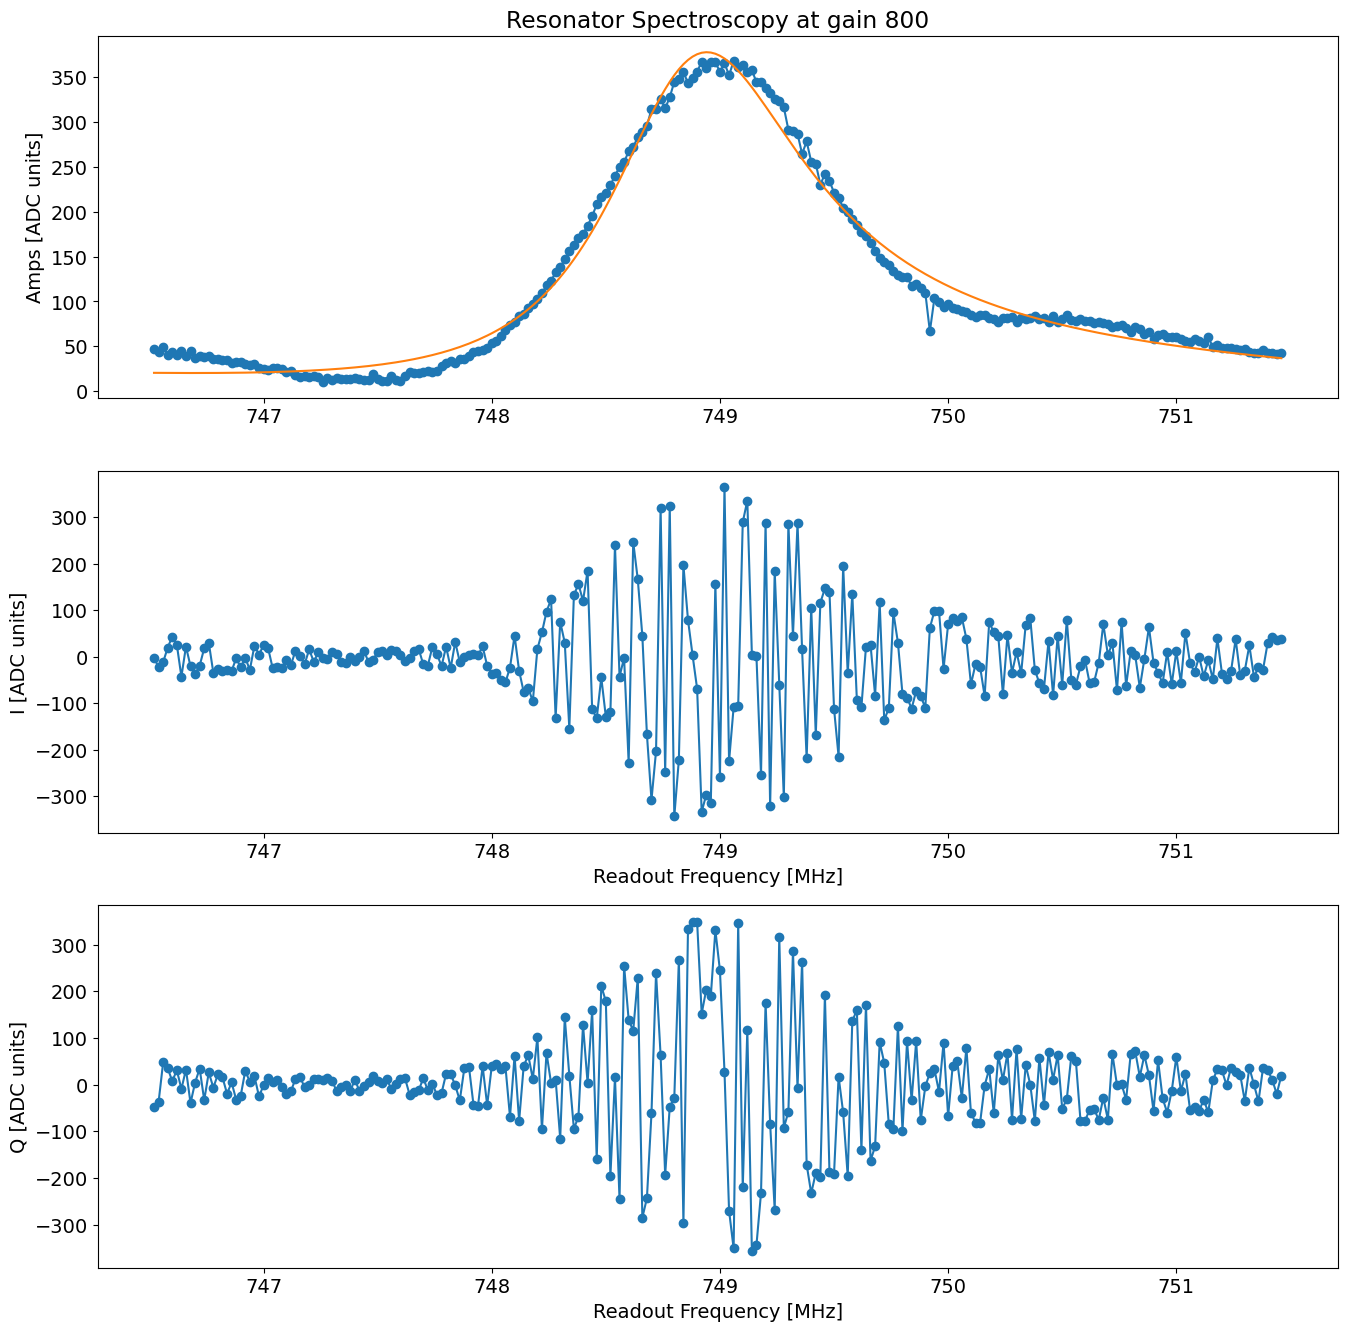

In [12]:
rspec = meas.single_qubit.resonator_spectroscopy.ResonatorSpectroscopyExperiment(
    soccfg=soc, path=expt_path, prefix='ResonatorSpectroscopyExperiment', config_file=config_path
)

rspec.cfg = AttrDict(deepcopy(config_thisrun))

rspec.cfg.expt = dict(
    start = 746.5, # resonator frequency to be mixed up [MHz]
    step = 0.02, # min step ~1 Hz
    expts = 250, # Number experiments stepping from start
    reps = 1000, # Number averages per point
    pulse_e = False, # add ge pi pulse prior to measurement
    pulse_f = False, # add ef pi pulse prior to measurement
    pulse_cavity = False,  # prepulse on cavity prior to measurement (False also disables next line)
    cavity_pulse = [4984.373226159381, 8000, 2, 0], # [frequency, gain, length, phase]  const pulse
    qubit = 0,
)

rspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
rspec.go(analyze=True, display=True, progress=True, save=True)

In [18]:
config_thisrun.device.readout.frequency = [rspec.data['fit'][0]]
print('Updated readout frequency!')

Updated readout frequency!


## Qubit ge

### Pulse-probe

  0%|          | 0/400000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00014_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3569.4784700689556, HWHM 0.652762514206398
Found peak in I at [MHz] 3569.4699726026793, HWHM 0.5898837746077152
Found peak in Q at [MHz] 3569.4847817804202, HWHM -0.6033996280578569


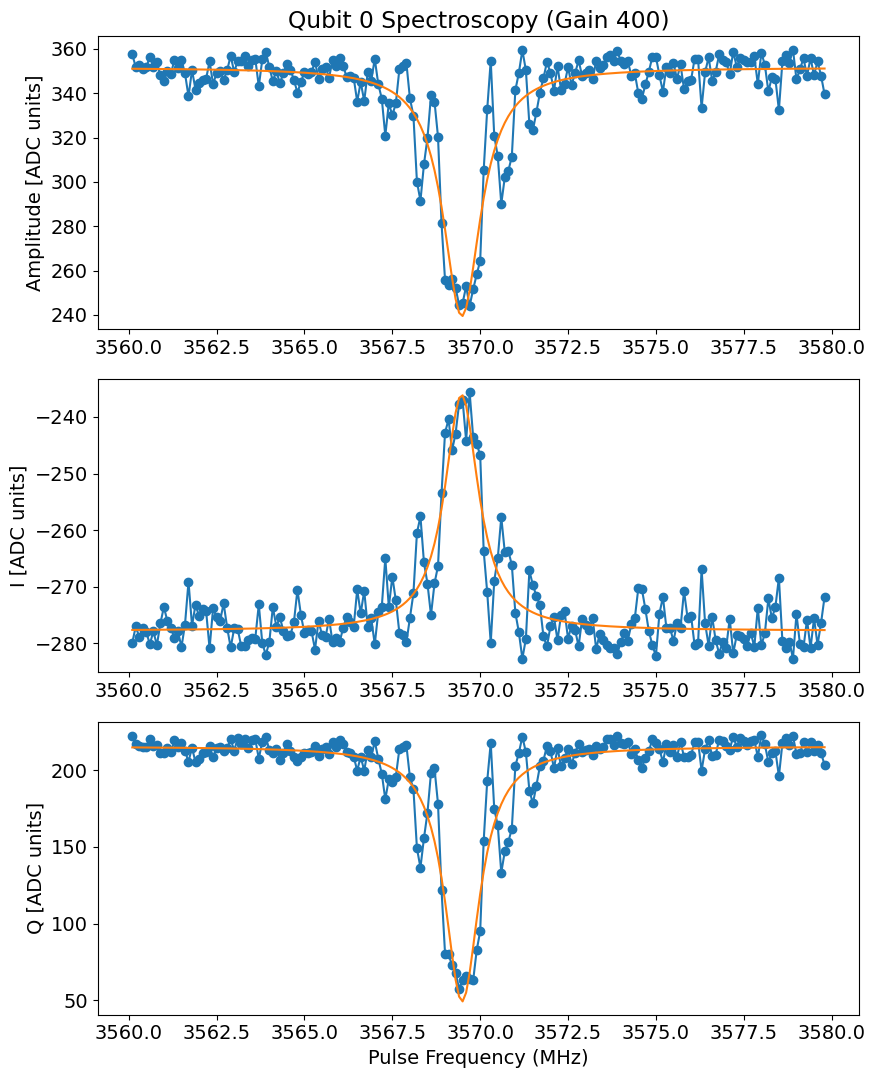

In [20]:
qspec = meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
    soccfg=soc, path=expt_path, prefix='PulseProbeSpectroscopyExperiment', config_file=config_path
)

qspec.cfg = AttrDict(deepcopy(config_thisrun))

qspec.cfg.expt = dict(
    start=3560,  # [MHz]
    step=0.1,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=2000,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=400,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    pulse_type='gaussian',
    wait_qubit=False,
    qubit=0,
    cavity_drive=False,
    cavity_name=0,  # 0 is man1, 1 is man2
    cavity_gain=4000,
    cavity_length=1,  # Constant pulses of cavity [us]
    cavity_pulse=[False, 0.1]  # Truth value for gaussian cavity pulse, type, sigma
)

qspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
qspec.go(analyze=True, display=True, progress=True, save=True)

In [21]:
config_thisrun.device.qubit.f_ge = [qspec.data['fit_amps'][2]]
print('Updated qubit ge frequency!')

Updated qubit ge frequency!


## Length Rabi (wrong, ignore)

  0%|          | 0/51 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00010_LengthRabiGeneralExperiment.h5
Decay from avgi [us] 15.012560693715296
Pi length from avgi data [us]: 0.052316314289161975
	Pi/2 length from avgi data [us]: 0.026158157144580987

Decay from avgq [us] 20.19674762984475
Pi length from avgq data [us]: 0.05231284777077127
Pi/2 length from avgq data [us]: 0.026156423885385634


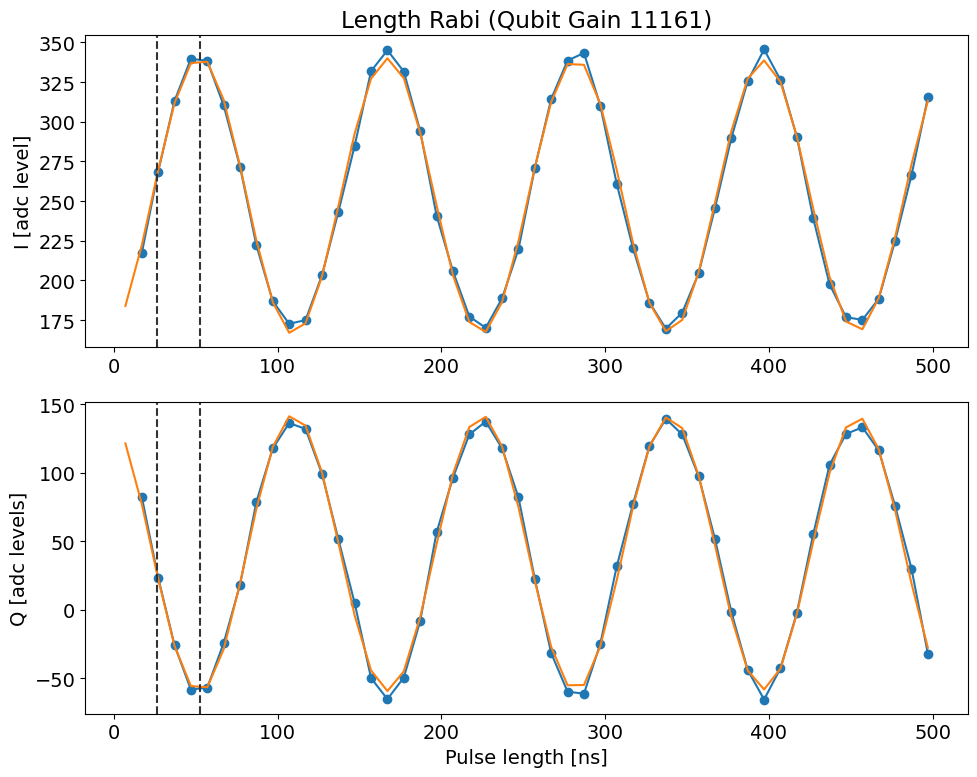

In [44]:
lengthrabi = meas.single_qubit.length_rabi_general.LengthRabiGeneralExperiment(
    soccfg=soc, path=expt_path, prefix='LengthRabiGeneralExperiment', config_file=config_path
)

lengthrabi.cfg = AttrDict(deepcopy(config_thisrun))

pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

lengthrabi.cfg.expt = dict(
    start= 0.007, # us
    step= 0.01, # us
    qubits= [0],
    expts= 51,
    reps= 2000,
    rounds= 1,
    gain= pulse_ge.gain[0], # qubit gain [DAC units],
    ramp_sigma= pulse_ge.sigma[0],  # us
    freq= config_thisrun.device.qubit.f_ge[0],   # MHz
    use_arb_waveform= False,
    pi_ge_before= False,
    pi_ef_before= False,
    pi_ge_after= False,
    prepulse= False, 
)

lengthrabi.cfg.device.readout.relax_delay = [1000] # Wait time between experiments [us]
lengthrabi.go(analyze=True, display=True, progress=True, save=True)

In [45]:
config_thisrun.device.qubit.pulses.pi_ge.length = [lengthrabi.data['pi_length_avgi']]
print('Updated qubit ge pi gaussian length!')

Updated qubit ge pi gaussian length!


In [46]:
# if hpi is done by dividing the gain:
config_thisrun.device.qubit.pulses.hpi_ge.length = [lengthrabi.data['pi_length_avgi']]
print('Updated qubit ge pi gaussian length!')

Updated qubit ge pi gaussian length!


## Amplitude Rabi

Readout phase: 77.3798467605903


  0%|          | 0/45300 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.001688888888888889, which is out of bounds 4.47427293064877e-06 to 0.0006711409395973154. Instead init to 0.0003378076062639821
Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00001_AmplitudeRabiExperiment.h5
Pi gain from avgi data [dac units]: 11230
	Pi/2 gain from avgi data [dac units]: 6292
Pi gain from avgq data [dac units]: 791
	Pi/2 gain from avgq data [dac units]: 768


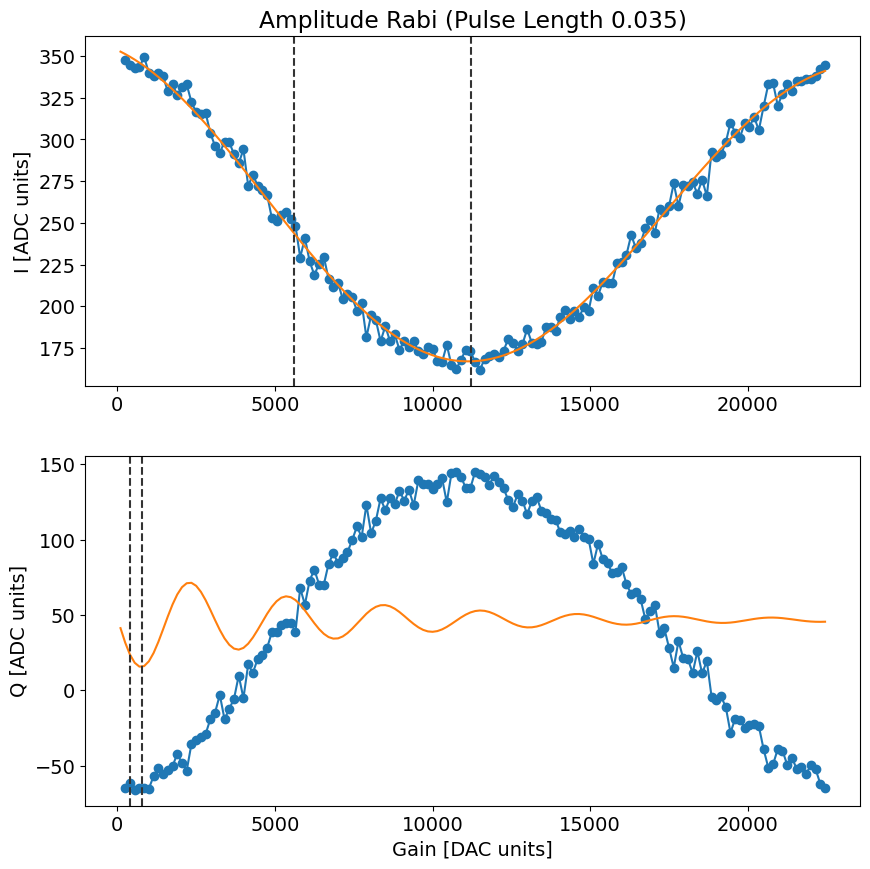

In [50]:
amprabi = meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
    soccfg=soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
)

amprabi.cfg = AttrDict(deepcopy(config_thisrun))

pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

amprabi.cfg.expt = dict(
    start=100,  # Qubit gain [dac level]
    step=150,  # [dac level]
    expts=151,
    reps=300,
    rounds=1,
    sigma_test=pulse_ge.sigma[0],  # Gaussian sigma for pulse length - overrides config [us]
    qubit=0,
    pulse_type='gauss',  # 'gauss' or 'flat_top' or 'drag' or 'const'
    drag_beta=0.0,
    pulse_ge=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,  # For debugging
    singleshot_reps=10000,
    span=50,  # Single shot plot span
    user_defined_freq=[False, 3568.203829046816],  # [on/off, freq]
    prepulse=False,
    postpulse=False
)

amprabi.cfg.device.readout.relax_delay = [1000] # Wait time between experiments [us]
amprabi.go(analyze=True, display=True, progress=True, save=True)

In [41]:
config_thisrun.device.qubit.pulses.pi_ge.gain = [amprabi.data['pi_length_avgi']]
print('Updated qubit ge pi gaussian gain!')

Updated qubit ge pi gaussian length!


# Legacy

In [12]:
# notuse expts
# experiment_class, experiment_name = 'single_qubit.single_shot_old', 'HistogramExperiment_oldold'
# experiment_class, experiment_name = 'single_qubit.single_shot', 'HistogramExperiment_old'
# experiment_class, experiment_name = 'qubit_cavity.non_demolution_readout', 'DemolutionMeasurementExperiment'


# experiment_class, experiment_name = 'single_qubit.phase_sweep', 'PhaseSweepExperiment'
# experiment_class, experiment_name = 'single_qubit.phase_sweep_averager', 'PhaseSweepAveragerExperiment'
# experiment_class, experiment_name = 'qubit_cavity.ecd', 'ECDExperiment'
# experiment_class, experiment_name = 'qubit_cavity.ecd_read_spec', 'ECDReadSpecExperiment'
# experiment_class, experiment_name = 'single_qubit.pulse_probe_ef_spectroscopy', 'PulseProbeEFSpectroscopyExperiment'
# experiment_class, experiment_name = 'qubit_cavity.single_mode_wigner_tomography', 'WignerTomography1ModeExperiment'
# experiment_class, experiment_name = 'qubit_cavity.single_mode_cats_wigner_tomography', 'WignerTomography1ModeCatExperiment'
# experiment_class, experiment_name = 'single_qubit.amplitude_rabi_general', 'AmplitudeRabiGeneralExperiment'
# experiment_class, experiment_name = 'single_qubit.amplitude_rabi_ef', 'AmplitudeRabiEFExperiment'
# experiment_class, experiment_name = 'single_qubit.t2_echo', 'RamseyEchoExperiment'
# experiment_class, experiment_name = 'single_qubit.t2_cavity', 'CavityRamseyExperiment_old'

# experiment_class, experiment_name = 'single_qubit.cavity2qubit', 'Cavity2QubitSweepExperiment'

In [23]:
# ---------------------- Readout ----------------------
# experiment_class, experiment_name = 'single_qubit.resonator_spectroscopy', 'ResonatorSpectroscopyExperiment' # for readout

# ---------------------- Qubit ----------------------
## Basic
# experiment_class, experiment_name = 'single_qubit.t1', 'T1Experiment'
# experiment_class, experiment_name = 'single_qubit.single_shot', 'HistogramExperiment'
# experiment_class, experiment_name = 'single_qubit.t2_ramsey', 'RamseyExperiment'
## Advanced
# experiment_class, experiment_name = 'single_qubit.amplitude_rabi', 'AmplitudeRabiExperiment' # <-------------- for ge and ef
# experiment_class, experiment_name = 'single_qubit.length_rabi_general', 'LengthRabiGeneralExperiment'
# experiment_class, experiment_name = 'single_qubit.pulse_probe_spectroscopy', 'PulseProbeSpectroscopyExperiment'
# experiment_class, experiment_name = 'single_qubit.pulse_probe_ef_spectroscopy', 'PulseProbeEFSpectroscopyExperiment'
# experiment_class, experiment_name = 'single_qubit.pulse_probe_spectroscopy_prepulse', 'PulseProbePrePulseSpectroscopyExperiment'

# ---------------------- Man Cavity ----------------------

experiment_class, experiment_name = 'single_qubit.cavity_spectroscopy', 'CavitySpectroscopyExperiment'
# experiment_class, experiment_name = 'single_qubit.length_rabi_f0g1_general', 'LengthRabiGeneralF0g1Experiment'
# experiment_class, experiment_name = 'single_qubit.t1_cavity', 'T1CavityExperiment'
# experiment_class, experiment_name = 'single_qubit.t2_cavity', 'CavityRamseyExperiment' # -------
# experiment_class, experiment_name = 'single_qubit.pulse_probe_f0g1_spectroscopy', 'PulseProbeF0g1SpectroscopyExperiment' # <--------------

# ---------------------- Storage ----------------------
# experiment_class, experiment_name = 'single_qubit.rf_flux_spectroscopy_f0g1', 'FluxSpectroscopyF0g1Experiment' 
# experiment_class, experiment_name = 'single_qubit.sideband_general', 'SidebandGeneralExperiment'
# experiment_class, experiment_name = 'single_qubit.sideband_t1_general', 'SidebandT1GeneralExperiment' # --------

## Wigner Tomography 
# experiment_class, experiment_name = 'single_qubit.parity_delay', 'ParityDelayExperiment'
# experiment_class, experiment_name = 'single_qubit.parity_gain', 'ParityGainExperiment'
# experiment_class, experiment_name = 'single_qubit.parity_freq', 'ParityFreqExperiment'

## Cavity Temperature 
# experiment_class, experiment_name = 'single_qubit.parity_measurement_temp', 'ParityTempExperiment'



# experiment_class, experiment_name = 'single_qubit.single_shot_prepulse','HistogramPrepulseExperiment'
# experiment_class, experiment_name = 'single_qubit.rb_ziqian', 'SingleRB'
# experiment_class, experiment_name = 'single_qubit.rbam', 'MultiRBAM'
# experiment_class, experiment_name = 'single_qubit.rb_BSgate', 'SingleBeamSplitterRB'
# experiment_class, experiment_name = 'single_qubit.rb_BSgate_postselection', 'SingleBeamSplitterRBPostSelection'
# experiment_class, experiment_name = 'single_qubit.rb_BSgate_check_target', 'SingleBeamSplitterRB_check_target'
# experiment_class, experiment_name = 'single_qubit.rb_BSgate_ramsey', 'SingleBeamSplitterRB_ramsey'
# experiment_class, experiment_name = 'qubit_cavity.displacement_enhanced_sideband', 'DisplacementEnhancedSidebandExperiment'

# experiment_class, experiment_name = 'qubit_cavity.out_and_back', 'OutAndBackExperiment'
# experiment_class, experiment_name = 'qubit_cavity.amplitude_rabi_f0g1', 'AmplitudeRabiF0g1Experiment'

# experiment_class, experiment_name = 'single_qubit.dragpulse_calibration', 'DragCalibrationExperiment' 
# experiment_class, experiment_name = 'single_qubit.fast_reset_test', 'FastResetExperiment'
# experiment_class, experiment_name = 'single_qubit.active_reset_single_shot', 'HistogramActiveResetExperiment'


# 

run_exp = eval(f"meas.{experiment_class}.{experiment_name}(soccfg=soc, path=expt_path, prefix=experiment_name, config_file=config_path)")


with open(exp_param_file, 'r') as file:

    # Load the YAML contents
    loaded = yaml.safe_load(file)
    run_exp.cfg.expt = eval(f"loaded['{experiment_name}']")

# special updates on device_config file
run_exp.cfg.device.readout.relax_delay = [500] # Wait time between experiments [us]
print(run_exp.cfg)
run_exp.go(analyze=False, display=False, progress=True, save=True)

{'device': {'qubit': {'T1': [127.0], 'f_ge': [3569.4934313126464], 'f_ef': [3426.2579958470365], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3], 'pulses': {'pi_ge': {'gain': [11161], 'sigma': [0.035], 'length': [0], 'type': 'gauss'}, 'pi_ge_ftop': {'gain': [3000], 'sigma': [0.005], 'length': [0.190914187445986], 'type': 'flat_top'}, 'pi_ge_fast': {'gain': [10682], 'sigma': [0.035], 'length': [0], 'type': 'gauss'}, 'pi_ge_resolved': {'gain': [50], 'sigma': [0.005], 'length': [6.553697146578866], 'type': 'flat_top', 'repeat_no': 1}, 'hpi_ge': {'gain': [5414], 'length': [0], 'sigma': [0.035], 'type': 'gauss'}, 'hpi_ge_ftop': {'gain': [3000], 'sigma': [0.005], 'length': [0.09131395179924079], 'type': 'flat_top'}, 'hpi_ge_fast': {'gain': [5195], 'length': [0], 'sigma': [0.035], 'type': 'gauss'}, 'pi_ef_ftop': {'gain': [3000], 'sigma': [0.005], 'length': [0.15377089082752435], 'type': 'flat_top'}, 'pi_ef_new': {'gain': [3000], 'sigma': [0.005], 'length': [0.15377089082752435], 'type': 'flat_to

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_CavitySpectroscopyExperiment.h5


In [14]:
soc.us2cycles(0.03, gen_ch = 1)

12

In [31]:
# quick pulse maker 
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(yaml_cfg)
# prep_stor = mm_base_dummy.prep_random_state_mode(2,1)  # prepare the storage state + 
# prep_man_hpi = mm_base_dummy.prep_random_state_mode(3, 1)[:-1]  # prepare the storage state +
prep_man_pi = mm_base_dummy.prep_man_photon(1)  # prepare the storage state +
mm_base_dummy.get_prepulse_creator(   prep_man_pi).pulse.tolist()


['ge', 'pi', 0]
['ef', 'pi', 0]


[[3569.4934313126464, 3426.2579958470365, 2009.01],
 [11161, 8483, 15000],
 [0, 0, 0.6301549458414055],
 [0, 0, 0],
 [2, 2, 0],
 ['g', 'g', 'flat_top'],
 [0.035, 0.035, 0.005]]

In [ ]:
prep_man

array([['qubit', 'ge', 'pi', '0'],
       ['qubit', 'ef', 'pi', '0'],
       ['man', 'M1', 'pi', '0']], dtype='<U11')

In [ ]:
# Sample NumPy array
my_array = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]).tolist()

# Reverse the array along axis 0
reversed_array = np.flip(my_array, axis=0).tolist() + my_array

reversed_array

[[7, 8, 9], [4, 5, 6], [1, 2, 3], [1, 2, 3], [4, 5, 6], [7, 8, 9]]

$\text{Gain (linear)} = 10^{\frac{\text{dB}}{20}} $

# Run sequential experiment

In [28]:
import multimode_expts.sequential_experiment as seq_exp

experiment_name = 'length_rabi_sweep'
# experiment_name = 'dc_flux_sweep'
# experiment_name = 'length_rabi_f0g1_sweep'
# experiment_name = 'manipulate_spectroscopy_dc_flux_sweep'
# experiment_name = 'gain_displace_sweep'
# experiment_name = 'sideband_general_sweep' # Deprecated

# --------- Sideband Experiment -----------
# experiment_class, experiment_name = 'sidebands_class', 'sideband_general_sweep'
# experiment_class, experiment_name = 'sidebands_class', 'sideband_gain_freq_sweep'
# experiment_class, experiment_name = 'sidebands_class', 'sideband_cross_kerr_cancellation'
# experiment_name = 'single_shot_phase_sweep'
# experiment_name = 'single_shot_freq_sweep'
# experiment_name = 'HistogramExperiment_freq_sweep'
# experiment_name = 'HistogramExperiment_ef_freq_sweep'
# experiment_name = 'single_shot_time_sweep'
# experiment_name = 'single_qubit_tomography'      # <--------------
# experiment_name = 'SingleRB_sweep_freq'
# experiment_name = 'SingleRB_sweep_pi_amp'
# experiment_name = 'SingleRB_sweep_hpi_amp'
# experiment_name = 'SingleRB_sweep_f0g1_phase'
# experiment_name = 'SingleRB_sweep_de|pth_and_prepulse'
# experiment_name = 'SingleRB_sweep_depth'
# experiment_name = 'MultiRBAM_sweep_depth'
# experiment_name = 'SingleBeamsplitterRB_sweep_depth'
# experiment_name = 'SingleBeamSplitterRB_sweep_freq'
# experiment_name = 'SingleBeamSplitterRB_gain_freq'
# experiment_name = 'pulseprobe_f0g1_dc_flux_sweep'
# experiment_name = 'PhaseSweepAverager_sweep_reps_middlepulse'
# experiment_name = 'cavity_t1_dc_flux_sweep'
# experiment_name = 'displace_enhanced_sweep'
# experiment_name = 'fluxspectroscopy_f0g1_dc_flux_sweep'
# experiment_name = 'storage_sideband_sweep'
# experiment_name = 'sideband_fidelity_optimization'
# experiment_name = 'storage_t1_optimization'
# experiment_name = 'SingleBeamSplitterRBPostSelection_sweep_depth'#
# experiment_name = 'SingleBeamSplitterRBPostSelection_sweep_depth_and_ram'
# experiment_name = 'SingleBeamSplitterRBPostSelection_sweep_depth_and_single_spec'
# experiment_name = 'DualRail_sweep_depth_and_single_spec_and_stor'
# experiment_name = 'SingleBeamSplitterRBPostSelection_sweep_depth_storsweep'
# experiment_name = 'SingleBeamSplitterRBPostSelection_sweep_depth_defined_storsweep'

# experiment_name = 'ramsey_sweep'
# experiment_name = 'cavity_ramsey_sweep'
# experiment_name = 'manipulate_dc_flux_sweep'
# experiment_name = 'rb_bs_optimization'
# experiment_name = 'rb_bs_dual_rail_optimization'
# experiment_name = 'cross_kerr_sweep'
# experiment_name = 'single_dual_rail_tomography'
# experiment_name = 'two_dual_rail_tomography'
# experiment_name = 'cavity_t1_dc_flux_sweep_new'
# experiment_name = 'cavity_temperature_sweep'
# experiment_name = 'cavity_temperature_sweep_parity'
# ---------------------- Dual Rail ----------------------
# experiment_class, experiment_name = 'MM_dual_rail_seq_exp', 'SingleBeamSplitterRB_check_target_sweep_depth'
# experiment_class, experiment_name = 'MM_dual_rail_seq_exp', 'SingleBeamSplitterRB_stor_ramsey_spec'
# experiment_class, experiment_name = 'MM_dual_rail_seq_exp', 'SingleBeamSplitterRB_stor_ramsey_spec_for_sp_pairs'


# ---------------------- Cavity RTamsey ----------------------
# experiment_class, experiment_name = 'sweep_cavity_ramsey_expts', 'cavity_temperature_sweep_parity_with_without_reset'
# experiment_class, experiment_name = 'sweep_cavity_ramsey_expts', 'cavity_ramsey_with_spectators'
# experiment_class, experiment_name = 'sweep_cavity_ramsey_expts', 'stor_cavity_ramsey_sweep'

# ---------------------- storage sweep-----------
# experiment_class, experiment_name = 'storage_sweep_class', 'storage_t1_sweep'


# # Option 1
# class_for_exp = eval('seq_exp.' + experiment_class)()
# eval('class_for_exp.' + experiment_name)(soccfg=soc, path=expt_path, prefix=experiment_name, config_file=config_path, exp_param_file=exp_param_file)

# Option 2
eval('seq_exp.' + experiment_name)(soccfg=soc, path=expt_path, prefix=experiment_name, config_file=config_path, exp_param_file=exp_param_file)

#Option 3
# class_for_exp = eval('seq_exp.' + experiment_class)(soccfg=soc, path=expt_path, prefix=experiment_name, config_file=config_path, exp_param_file=exp_param_file)
# eval('class_for_exp.run_sweep')( sweep_experiment_name = experiment_name)


Config will be C:\_Lib\python\multimode_expts\config_analysis.yml
Index: 0 Freq. = 3420.0 GHz
Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_length_rabi_sweep.h5
Index: 1 Freq. = 3421.0 GHz
Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00001_length_rabi_sweep.h5
Index: 2 Freq. = 3422.0 GHz
Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00002_length_rabi_sweep.h5
Index: 3 Freq. = 3423.0 GHz
Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00003_length_rabi_sweep.h5
Index: 4 Freq. = 3424.0 GHz
Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00004_length_rabi_sweep.h5
Index: 5 Freq. = 3425.0 GHz
Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00005_length_rabi_sweep.h5
Index: 6 Freq. = 3426.0 GHz
Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00006_length_rabi_sweep.h5
Index: 7 Freq. = 3427.0 GHz
Saving H:\Shared drives\SLab\Multimode\experiment\25

NameError: name 'class_for_exp' is not defined

In [ ]:
import multimode_expts.qsim_experiments as qsim_exp

# ---------------------- qsim sweep-----------
experiment_class, experiment_name = 'floquet_swap_class', 'storage_sweep'


class_for_exp = eval('qsim_exp.' + experiment_class)(soccfg=soc, path=expt_path, prefix=experiment_name, config_file=config_path, exp_param_file=os.path.join(curr_path, 'qsim_exp_cfg.yml'))
eval('class_for_exp.run_sweep')( sweep_experiment_name = experiment_name)


Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 1}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 1}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00595_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 6}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 6}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00596_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 11}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 11}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00597_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 16}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 16}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00598_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 21}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 21}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00599_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 26}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 26}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00600_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 31}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 31}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00601_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 36}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 36}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00602_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 41}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 41}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00603_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 46}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 46}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00604_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 51}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 51}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00605_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 56}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 56}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00606_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 61}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 61}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00607_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 66}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 66}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00608_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 71}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 71}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00609_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 76}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 76}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00610_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 81}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 81}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00611_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 86}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 86}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00612_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 91}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 91}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00613_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 96}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 96}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00614_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 101}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 101}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00615_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 106}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 106}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00616_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 111}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 111}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00617_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 116}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 116}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00618_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 121}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 121}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00619_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 126}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 126}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00620_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 131}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 131}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00621_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 136}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 136}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00622_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 141}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 141}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00623_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 146}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 146}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00624_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 151}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 151}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00625_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 156}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 156}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00626_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 161}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 161}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00627_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 166}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 166}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00628_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 171}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 171}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00629_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 176}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 176}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00630_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 181}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 181}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00631_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 186}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 186}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00632_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 191}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 191}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00633_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 196}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 196}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00634_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 201}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 201}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00635_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 206}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 206}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00636_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 211}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 211}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00637_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 216}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 216}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00638_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 221}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 221}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00639_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 226}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 226}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00640_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 231}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 231}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00641_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 236}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 236}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00642_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 241}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 241}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00643_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 246}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 246}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00644_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 251}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 251}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00645_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 256}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 256}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00646_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 261}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 261}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00647_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 266}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 266}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00648_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 271}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 271}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00649_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 276}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 276}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00650_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 281}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 281}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00651_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 286}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 286}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00652_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 291}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 291}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00653_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 296}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 296}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00654_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 301}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 301}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00655_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 306}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 306}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00656_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 311}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 311}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00657_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 316}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 316}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00658_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 321}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 321}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00659_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 326}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 326}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00660_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 331}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 331}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00661_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 336}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 336}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00662_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 341}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 341}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00663_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 346}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 346}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00664_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 351}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 351}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00665_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 356}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 356}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00666_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 361}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 361}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00667_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 366}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 366}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00668_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 371}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 371}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00669_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 376}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 376}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00670_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 381}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 381}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00671_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 386}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 386}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
['ge', 'pi', 0]
['ef', 'pi', 0]
Saving H:\Shared drives\SLab\Multimode\experiment\250307_qsim\data\00672_storage_sweep.h5
Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 391}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 391}


  0%|          | 0/7 [00:00<?, ?it/s]

['ge', 'pi', 0]
['ef', 'pi', 0]


ValueError: could not broadcast input array from shape (65902,) into shape (65536,)

In [15]:
class_for_exp.loaded['SidebandT1GeneralExperiment']

NameError: name 'class_for_exp' is not defined

In [ ]:
experiment_class = 'sidebands_class'
class_for_exp = eval('seq_exp.' + experiment_class)(soccfg=soc, path=expt_path, prefix=experiment_name, config_file=config_path, exp_param_file=exp_param_file)

In [ ]:
class_for_exp.run_sweep

<bound method sidebands_class.run_sweep of <multimode_expts.sequential_experiment.sidebands_class object at 0x0000028220427700>>

In [ ]:
np.array([
                    349.66, # 349.415, 
                    521.23, #520.925,
                    696.98, #696.665,
                    876.38, #875.845,
                    1053.95, #1053.395,
                    1245.52, # 1245.5, #1245.16,
                    1423.27 #1423.04
                    ]) + 1

array([ 350.66,  522.23,  697.98,  877.38, 1054.95, 1246.52, 1424.27])

In [ ]:
class_for_exp.cavity_ramsey_with_spectators(soccfg=soc, path=expt_path, prefix=experiment_name, config_file=config_path, exp_param_file=exp_param_file)

TypeError: cavity_ramsey_with_spectators() got multiple values for argument 'soccfg'

In [ ]:
soc

In [ ]:
from multimode_expts.MM_rb_base import  *

f0g1_pulse_str = [['qubit', 'ge', 'pi', 0],
                    ['qubit', 'ef', 'pi', 0],
                    ['man', 'M1', 'pi', 0]]

mm_base = MM_rb_base(cfg = yaml_cfg)
creator = mm_base.get_prepulse_creator(f0g1_pulse_str)
creator.pulse.tolist()


[[3568.497301707094, 3425.2997709216247, 2007.54],
 [10973, 9530, 15000],
 [0, 0, 0.6164057205175526],
 [0, 0, 0],
 [2, 2, 0],
 ['g', 'g', 'flat_top'],
 [0.035, 0.035, 0.005]]

In [ ]:
from MM_base import MM_base
stor_no=1
man_idx=1
mm_base = MM_base(cfg = yaml_cfg)
pre_sweep_pulse_str = [
    ['man', 'M' + str(man_idx) , 'pi',0],
                       ['qubit', 'ef', 'pi',0]]
creator = mm_base.get_prepulse_creator(pre_sweep_pulse_str)
a1 = creator.pulse.tolist()
a1


In [ ]:
from MM_base import MM_base
stor_no=1
man_idx=1
mm_base = MM_base(cfg = yaml_cfg)
pre_sweep_pulse_str = [['storage', 'M'+ str(man_idx) + '-S' + str(stor_no), 'pi',0],
    ['qubit', 'ge', 'hpi',0], # Starting parity meas
                ['qubit', 'ge', 'parity_M' + str(man_idx),0], 
                ['qubit', 'ge', 'hpi',0]]
creator = mm_base.get_prepulse_creator(pre_sweep_pulse_str)
a1 = creator.pulse.tolist()
a1


[[349.415, 3568.1515953227604, 3568.1515953227604, 3568.1515953227604],
 [3000, 5510, 0, 5510],
 [0.9771428571428572, 0, 1.6833333333333333, 0],
 [0, 0, 0, 0],
 [1, 2, 2, 2],
 ['flat_top', 'g', 'const', 'g'],
 [0.005, 0.035, 0.0, 0.035]]

In [ ]:
from MM_base import MM_base
stor_no=[1,2]
man_idx=1
mm_base = MM_base(cfg = yaml_cfg)
pre_sweep_pulse_str = [['qubit', 'ge', 'pi',0],
                    ['qubit', 'ef', 'pi',0],
                    ['man', 'M' + str(man_idx) , 'pi',0],
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[0]), 'hpi',0], 
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1]), 'hpi',0],
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1]), 'hpi',0]]

creator = mm_base.get_prepulse_creator(pre_sweep_pulse_str)
a1 = creator.pulse.tolist()
a1


[[3568.1751638611518, 3425.5564066067, 2007.06, 349.415, 520.925, 520.925],
 [10716, 8236, 15000, 3000, 5000, 5000],
 [0, 0, 0.651287, 0.4885714285714285, 0.565451994946885, 0.565451994946885],
 [0, 0, 0, 0, 0, 0],
 [2, 2, 0, 1, 1, 1],
 ['g', 'g', 'flat_top', 'flat_top', 'flat_top', 'flat_top'],
 [0.035, 0.035, 0.005, 0.005, 0.005, 0.005]]

In [ ]:
from MM_base import MM_base
stor_no=[[1,2],[3,4]]
man_idx=1
mm_base = MM_base(cfg = yaml_cfg)
pre_sweep_pulse_str = [['qubit', 'ge', 'pi',0],
                    ['qubit', 'ef', 'pi',0],
                    ['man', 'M' + str(man_idx) , 'pi',0],
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[0][0]), 'hpi',0], 
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[0][1]), 'hpi',0],
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[0][1]), 'hpi',0],
                    ['qubit', 'ge', 'pi',0],
                    ['qubit', 'ef', 'pi',0],
                    ['man', 'M' + str(man_idx) , 'pi',0],
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1][0]), 'hpi',0], 
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1][1]), 'hpi',0], 
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1][1]), 'hpi',0]]

creator = mm_base.get_prepulse_creator(pre_sweep_pulse_str)
a1 = creator.pulse.tolist()
a1

[[3568.1751638611518,
  3425.5564066067,
  2007.06,
  349.415,
  520.925,
  520.925,
  3568.1751638611518,
  3425.5564066067,
  2007.06,
  696.665,
  875.845,
  875.845],
 [10716, 8236, 15000, 3000, 5000, 5000, 10716, 8236, 15000, 9000, 9000, 9000],
 [0,
  0,
  0.651287,
  0.4885714285714285,
  0.565451994946885,
  0.565451994946885,
  0,
  0,
  0.651287,
  0.666955,
  0.6271437312608766,
  0.6271437312608766],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 0, 1, 1, 1, 2, 2, 0, 1, 1, 1],
 ['g',
  'g',
  'flat_top',
  'flat_top',
  'flat_top',
  'flat_top',
  'g',
  'g',
  'flat_top',
  'flat_top',
  'flat_top',
  'flat_top'],
 [0.035,
  0.035,
  0.005,
  0.005,
  0.005,
  0.005,
  0.035,
  0.035,
  0.005,
  0.005,
  0.005,
  0.005]]

In [ ]:
stor_no=[3,4]
man_idx=1
post_selection_pulse_str = [['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[0]), 'hpi',0], 
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[0]), 'hpi',0],
                ['qubit', 'ge', 'hpi',0], # Starting parity meas
                ['qubit', 'ge', 'parity_M' + str(man_idx),0], 
                ['qubit', 'ge', 'hpi',0]]# measure]
creator = mm_base.get_prepulse_creator(post_selection_pulse_str)
I_gate1 = creator.pulse.tolist()
post_selection_pulse_str = [
                ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1]), 'hpi',0], 
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1]), 'hpi',0],
                ['qubit', 'ge', 'hpi',0], # Starting parity meas
                ['qubit', 'ge', 'parity_M' + str(man_idx),0], 
                ['qubit', 'ge', 'hpi',0]]# measure]
creator = mm_base.get_prepulse_creator(post_selection_pulse_str)
I_gate2 = creator.pulse.tolist()


I_gate = [I_gate1, I_gate2]

post_selection_pulse_str = [['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[0]), 'hpi',0], 
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[0]), 'hpi',0],
                ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1]), 'hpi',0], 
                ['qubit', 'ge', 'hpi',0], # Starting parity meas
                ['qubit', 'ge', 'parity_M' + str(man_idx),0], 
                ['qubit', 'ge', 'hpi',0]]
creator = mm_base.get_prepulse_creator(post_selection_pulse_str)
X_gate1 = creator.pulse.tolist()
post_selection_pulse_str = [['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1]), 'hpi',0], 
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1]), 'hpi',0],
                ['qubit', 'ge', 'hpi',0], # Starting parity meas
                ['qubit', 'ge', 'parity_M' + str(man_idx),0], 
                ['qubit', 'ge', 'hpi',0]]
creator = mm_base.get_prepulse_creator(post_selection_pulse_str)
X_gate2 = creator.pulse.tolist()

X_gate = [X_gate1, X_gate2]

post_selection_pulse_str = [['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[0]), 'hpi',0], 
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[0]), 'hpi',0],
                ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1]), 'hpi',90], 
                ['qubit', 'ge', 'hpi',0], # Starting parity meas
                ['qubit', 'ge', 'parity_M' + str(man_idx),0], 
                ['qubit', 'ge', 'hpi',0]]
creator = mm_base.get_prepulse_creator(post_selection_pulse_str)
Y_gate1 = creator.pulse.tolist()
post_selection_pulse_str = [['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1]), 'hpi',0], 
                    ['storage', 'M'+ str(man_idx) + '-S' + str(stor_no[1]), 'hpi',0],
                ['qubit', 'ge', 'hpi',0], # Starting parity meas
                ['qubit', 'ge', 'parity_M' + str(man_idx),0], 
                ['qubit', 'ge', 'hpi',0]]
creator = mm_base.get_prepulse_creator(post_selection_pulse_str)
Y_gate2 = creator.pulse.tolist()

Y_gate = [Y_gate1, Y_gate2]

# Prepulse and Postpulse generator

## Dataset

In [ ]:
from dataset import * 
from dataset import storage_man_swap_dataset


In [ ]:
dataset = storage_man_swap_dataset('man1_storage_swap_dataset.csv')
dataset.df

,stor_name,freq (MHz),precision (MHz),pi (mus),h_pi (mus),gain (DAC units),last_update
0,M1-S1,348.85,0.01,0.784259,0.343947,3000,2025-03-11 12:35:25.500986
1,M1-S2,520.32,0.05,0.938822,0.423037,5000,2025-03-27 21:05:57.941851
2,M1-S3,696.02,0.05,1.134706,0.527018,9000,2025-03-12 11:21:11.606511
3,M1-S4,873.75,0.05,1.082605,0.506007,9000,2025-03-27 19:04:37.148499
4,M1-S5,1052.65,0.05,1.735148,0.820643,7500,2025-03-12 10:41:05.165443
5,M1-S6,1244.52,0.05,1.372186,0.637996,13500,2025-03-12 09:53:56.486329
6,M1-S7,1422.35,0.05,1.964983,0.927853,10000,2025-03-12 09:14:13.544748
7,M1-S8,-1.00,-1.00,-1.000000,-1.000000,-1,51:31.3
8,M1-S9,-1.00,-1.00,-1.000000,-1.000000,-1,51:31.3
9,M1-S10,-1.00,-1.00,-1.000000,-1.000000,-1,51:31.3


## Adding dump and coupler swaps to the dataset

In [ ]:
# ##[2313.3, 5000, , 2, 2], 
# #[2093.9, , 15, 2, 2] 
ds = dataset
# M1-D1
ds.append_dataset('M1-D1', 2313.3, 0.01, 10, 0, 5000)
#M2 - D2
ds.append_dataset('M2-D2', 2093.9, 0.01, 15, 0, 8000)
# M1-C (coupler)
ds.append_dataset('M1-C', 944.25, 0.01, 0.316677658, 0.158422064, 1000)

C:\_Lib\python\multimode_expts\dataset.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(new_row, ignore_index=True)
C:\_Lib\python\multimode_expts\dataset.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(new_row, ignore_index=True)
C:\_Lib\python\multimode_expts\dataset.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(new_row, ignore_index=True)


## New Creator

In [20]:
from multimode_expts.MM_base import *
mm_base = MM_base(cfg = yaml_cfg)

man_idx = 1
stor_id = [1,2]

## Parity Meas
parity_str = [['qubit', 'ge', 'hpi', 0 ], # Starting parity meas
                ['qubit', 'ge', 'parity_M' + str(man_idx), 0 ], 
                ['qubit', 'ge', 'hpi', 0 ], 
                ]

# parity_str_multiple

## Prepapre Man1 photon
prep_man_pi = [
                ['qubit', 'ge', 'pi', 0],
                ['qubit', 'ef', 'pi', 0],
                ['man', 'M1', 'pi', 0]
            ]
post_f0g1_str_for_ramsey = [['man', 'M1', 'pi', 0],
                ['qubit', 'ef', 'pi', 0], 
                ['qubit', 'ge', 'hpi', 0]]
storage = [['storage', 'M1-S1', 'pi', 0]   ]

man = [['man', 'M1', 'pi', 0]   ]

prep_stor = [
                ['qubit', 'ge', 'hpi', 0],
                ['qubit', 'ef', 'pi', 0],
                # ['man', 'M1', 'pi', 0],
                # ['storage', 'M1-S3', 'pi', 0]  ,
                   ]


    
creator = mm_base.get_prepulse_creator( prep_stor[::-1])
creator.pulse.tolist()
# pulse_str

['ef', 'pi', 0]
['ge', 'hpi', 0]


[[3426.2961712804477, 3569.4934313126464],
 [8483, 5414],
 [0, 0],
 [0, 0],
 [2, 2],
 ['g', 'g'],
 [0.035, 0.035]]

In [ ]:
prep_stor[-1]

['storage', 'M1-S2', 'pi', 0]

# Ramp Current

In [ ]:
# coupler
dcflux = YokogawaGS200(address="192.168.137.148")
dcflux.set_output(True)
dcflux.set_mode('current')
dcflux.ramp_current(0.00032, sweeprate=0.0001)

In [ ]:
# jpa
dcflux = YokogawaGS200(address="192.168.137.149")
dcflux.set_output(True)
dcflux.set_mode('current')
dcflux.ramp_current(0.000, sweeprate=0.002)

dcflux = YokogawaGS200(address="192.168.137.148")
    dcflux.set_output(True)
    dcflux.set_mode('current')
    dcflux.ramp_current(0.000, sweeprate=0.002)